In [1]:
#import some stuff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
import glob
import time
import xgboost as xgb
from sklearn.model_selection import train_test_split #use this?
from scipy import stats
from sklearn.metrics import log_loss, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import GridSearchCV

In [2]:
urlScout = 'https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_scouting.csv'
urlWomen = 'https://raw.githubusercontent.com/bigdatacup/Big-Data-Cup-2021/main/hackathon_womens.csv'
dataScout = pd.read_csv(urlScout)
dataWomen = pd.read_csv(urlWomen)

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
dataScout.head(1)

,game_date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,Player,Event,X Coordinate,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2
0,2019-09-20,Erie Otters,Sudbury Wolves,1,20:00,5,5,0,0,Sudbury Wolves,Blake Murray,Faceoff Win,100,43,Forehand,NaN,NaN,NaN,Connor Lockhart,NaN,NaN


In [5]:
dataWomen.head(1)

,game_date,Home Team,Away Team,Period,Clock,Home Team Skaters,Away Team Skaters,Home Team Goals,Away Team Goals,Team,Player,Event,X Coordinate,Y Coordinate,Detail 1,Detail 2,Detail 3,Detail 4,Player 2,X Coordinate 2,Y Coordinate 2
0,2018-02-11,Olympic (Women) - Canada,Olympic (Women) - Olympic Athletes from Russia,1,20:00,5,5,0,0,Olympic (Women) - Canada,Emily Clark,Faceoff Win,100,42,Backhand,NaN,NaN,NaN,Lyudmila Belyakova,NaN,NaN


In [6]:
a = np.array(dataWomen[['game_date','Home Team','Away Team']]).astype("<U22")
print('There are ',len(np.unique(a,axis=0)),' games in the women dataset')
b = np.array(dataScout[['game_date','Home Team','Away Team']]).astype("<U22")
print('There are ',len(np.unique(b,axis=0)),' games in the scout dataset')

There are  13  games in the women dataset
There are  40  games in the scout dataset


In [7]:
print('Amount of Passes for Women:',len(dataWomen.loc[(dataWomen['Event'] ==  'Play' ) | (dataWomen['Event'] == 'Incomplete Play')]))
print('Amount of Shots for Women:',len(dataWomen.loc[(dataWomen['Event'] ==  'Shot' ) | (dataWomen['Event'] == 'Goal')]))
print('Amount of Passes for Scout:',len(dataScout.loc[(dataScout['Event'] ==  'Play' ) | (dataScout['Event'] == 'Incomplete Play')]))
print('Amount of Shots for Scout:',len(dataScout.loc[(dataScout['Event'] ==  'Shot' ) | (dataScout['Event'] == 'Goal')]))

Amount of Passes for Women: 10105
Amount of Shots for Women: 1671
Amount of Passes for Scout: 32668
Amount of Shots for Scout: 5180


In [8]:
#dataScout.loc[(dataScout['Event'] ==  'Shot' ) | (dataScout['Event'] == 'Goal')].head(1)

In [9]:
#here this will help make an xGoals model
def getDataReadyxGoalsSimple(df):
    df = df.copy()
    
    filteredDF = df.loc[(df['Event'] ==  'Shot' ) | (df['Event'] == 'Goal')].copy() #only need these rows
    filteredDF['TeamSkaters'] = filteredDF.apply(lambda row: row['Home Team Skaters'] if (row['Team'] == row['Home Team']) else row['Away Team Skaters'],axis=1)
    filteredDF['OppSkaters'] = filteredDF.apply(lambda row: row['Home Team Skaters'] if (row['Team'] == row['Away Team']) else row['Away Team Skaters'],axis=1)
    filteredDF['onPP'] = filteredDF.apply(lambda row: 1*((row['TeamSkaters'] > row['OppSkaters']) & (row['OppSkaters'] < 5)),axis=1)
    filteredDF['onPK'] = filteredDF.apply(lambda row: 1*((row['TeamSkaters'] < row['OppSkaters']) & (row['TeamSkaters'] < 5)),axis=1)
    filteredDF['TeamEmptyNet'] = filteredDF.apply(lambda row: 1*(row['TeamSkaters'] > 6),axis=1)
    filteredDF['OppEmptyNet'] = filteredDF.apply(lambda row: 1*(row['OppSkaters'] > 6),axis=1)
    filteredDF['AmountExtraSkaters'] = filteredDF.apply(lambda row: row['TeamSkaters'] - row['OppSkaters'],axis=1)
    filteredDF['Goal'] = filteredDF.apply(lambda row: 1 if (row['Event'] == 'Goal') else 0,axis=1)
    #we don't include detail 2 since that would bias the results toward 'on net' being the best
    #it's info we don't know at the shot time
    filteredDF['DistanceToCenterGoal'] = filteredDF.apply(lambda row: ((189 - row['X Coordinate'])**2 + (42.5 - row['Y Coordinate'])**2)**0.5,axis=1)
    def getAreaNet(x,y):
        if y > 42.5:
            y = 85 - y #so it's like we're on the bottom side of the rink - mirror doesn't matter
        hyp = ((189 - x)**2 + (39.5 - y)**2)**0.5
        vector1 = [189 - x, 39.5 - y]
        vector2 = [189 - x, 45.5 - y]
        unit_vector_1 = vector1 / np.linalg.norm(vector1)
        unit_vector_2 = vector2 / np.linalg.norm(vector2)
        dot_product = np.dot(unit_vector_1, unit_vector_2)
        angle = np.arccos(dot_product)
        angle = angle / 2 #using angle bisector for triangle
        halfNet = np.sin(angle) * hyp
        fullNet = 2 * halfNet
        return fullNet*4
    filteredDF['SurfaceAreaNetSeen'] = filteredDF.apply(lambda row: getAreaNet(row['X Coordinate'],row['Y Coordinate']),axis=1)
    filteredDF['SurfaceAreaNetSeen'] = filteredDF.apply(lambda row: 0 if (row['X Coordinate'] > 189) else row['SurfaceAreaNetSeen'],axis=1)
    
    #this is for the small df
    filteredDF = filteredDF[['onPP','onPK','TeamEmptyNet','OppEmptyNet','AmountExtraSkaters','DistanceToCenterGoal','SurfaceAreaNetSeen','Goal']]
    X = filteredDF.iloc[:,:-1]
    y = filteredDF.iloc[:,-1]
    return X,y

In [23]:
#here this will help make an xGoals model
def getDataReadyxGoalsComplex(df):
    df = df.copy()
    df['isFaceOff'] = df['Event'].apply(lambda row: row == 'Faceoff Win')
    df['SecondsLeft'] = df['Clock'].apply(lambda row: float(row.split(':')[0]) * 60 + float(row.split(':')[1]))
    df['ChangeInPoss'] = (df['Team'] != df['Team'].shift(1))
    df['ChangeInPoss'] = df.apply(lambda row: True if (row['Event'] == 'Faceoff Win') else row['ChangeInPoss'],axis=1)
    df = df.rename(columns={'ChangeInPoss':'PossStart'})
    df['PossStartTime'] = df.apply(lambda row: row['SecondsLeft'] if row['PossStart'] else -1.0,axis=1)
    for i in range(len(df)):
        if df.loc[i,'PossStartTime'] == -1.0:
            df.loc[i,'PossStartTime'] = df.loc[i-1,'PossStartTime']
    df['PossTotalTime'] = df.apply(lambda row: row['PossStartTime'] - row['SecondsLeft'],axis=1)
    df['LastEvent'] = df['Event'].shift(1)
    df['TimeBetweenEvents'] = df['SecondsLeft'].shift(1,fill_value=1200) - df['SecondsLeft']
    df = df.drop(columns=['PossStart','PossStartTime']) #drop these cuz I don't think I need them
    
    filteredDF = df.loc[(df['Event'] ==  'Shot' ) | (df['Event'] == 'Goal')].copy() #only need these rows
    filteredDF['fromPass'] = filteredDF.apply(lambda row: 1 if (row['LastEvent'] == 'Play') else 0,axis=1)
    filteredDF['TeamSkaters'] = filteredDF.apply(lambda row: row['Home Team Skaters'] if (row['Team'] == row['Home Team']) else row['Away Team Skaters'],axis=1)
    filteredDF['OppSkaters'] = filteredDF.apply(lambda row: row['Home Team Skaters'] if (row['Team'] == row['Away Team']) else row['Away Team Skaters'],axis=1)
    filteredDF['onPP'] = filteredDF.apply(lambda row: 1*((row['TeamSkaters'] > row['OppSkaters']) & (row['OppSkaters'] < 5)),axis=1)
    filteredDF['onPK'] = filteredDF.apply(lambda row: 1*((row['TeamSkaters'] < row['OppSkaters']) & (row['TeamSkaters'] < 5)),axis=1)
    filteredDF['TeamEmptyNet'] = filteredDF.apply(lambda row: 1*(row['TeamSkaters'] > 6),axis=1)
    filteredDF['OppEmptyNet'] = filteredDF.apply(lambda row: 1*(row['OppSkaters'] > 6),axis=1)
    filteredDF['AmountExtraSkaters'] = filteredDF.apply(lambda row: row['TeamSkaters'] - row['OppSkaters'],axis=1)
    filteredDF['Goal'] = filteredDF.apply(lambda row: 1 if (row['Event'] == 'Goal') else 0,axis=1)
    filteredDF['TypeDeflection'] = filteredDF.apply(lambda row: 1 if (row['Detail 1'] == 'Deflection') else 0,axis=1)
    filteredDF['TypeSlapshot'] = filteredDF.apply(lambda row: 1 if (row['Detail 1'] == 'Slapshot') else 0,axis=1)
    filteredDF['TypeSnapshot'] = filteredDF.apply(lambda row: 1 if (row['Detail 1'] == 'Snapshot') else 0,axis=1)
    filteredDF['TypeWrapAround'] = filteredDF.apply(lambda row: 1 if (row['Detail 1'] == 'Wrap Around') else 0,axis=1)
    filteredDF['TypeWristshot'] = filteredDF.apply(lambda row: 1 if (row['Detail 1'] == 'Wristshot') else 0,axis=1)
    #we don't include detail 2 since that would bias the results toward 'on net' being the best
    #it's info we don't know at the shot time
    filteredDF['isTraffic'] = filteredDF.apply(lambda row: 1 if (row['Detail 3'] == 't') else 0,axis=1)
    filteredDF['isOneTimer'] = filteredDF.apply(lambda row: 1 if (row['Detail 4'] == 't') else 0,axis=1)
    filteredDF['DistanceToCenterGoal'] = filteredDF.apply(lambda row: ((189 - row['X Coordinate'])**2 + (42.5 - row['Y Coordinate'])**2)**0.5,axis=1)
    def getAreaNet(x,y):
        if y > 42.5:
            y = 85 - y #so it's like we're on the bottom side of the rink - mirror doesn't matter
        hyp = ((189 - x)**2 + (39.5 - y)**2)**0.5
        vector1 = [189 - x, 39.5 - y]
        vector2 = [189 - x, 45.5 - y]
        unit_vector_1 = vector1 / np.linalg.norm(vector1)
        unit_vector_2 = vector2 / np.linalg.norm(vector2)
        dot_product = np.dot(unit_vector_1, unit_vector_2)
        angle = np.arccos(dot_product)
        angle = angle / 2 #using angle bisector for triangle
        halfNet = np.sin(angle) * hyp
        fullNet = 2 * halfNet
        return fullNet*4
    filteredDF['SurfaceAreaNetSeen'] = filteredDF.apply(lambda row: getAreaNet(row['X Coordinate'],row['Y Coordinate']),axis=1)
    filteredDF['SurfaceAreaNetSeen'] = filteredDF.apply(lambda row: 0 if (row['X Coordinate'] > 189) else row['SurfaceAreaNetSeen'],axis=1)
    
    filteredDF['GoalsDown'] = filteredDF.apply(lambda row: (row['Home Team Goals'] - row['Away Team Goals'])
                                              if (row['Team'] == row['Away Team Goals'])
                                              else (row['Away Team Goals'] - row['Home Team Goals']),axis=1)
    filteredDF = filteredDF[['PossTotalTime','onPP','onPK','AmountExtraSkaters','fromPass','TimeBetweenEvents',
                      'TypeDeflection','TypeSlapshot','TypeSnapshot','TypeWrapAround','TypeWristshot','TeamEmptyNet','OppEmptyNet',
                      'isTraffic','isOneTimer','DistanceToCenterGoal','SurfaceAreaNetSeen','Goal']] 
    
    X = filteredDF.iloc[:,:-1]
    y = filteredDF.iloc[:,-1]
    return X,y

# Here we make the complex model

In [24]:
XxGoals,yxGoals = getDataReadyxGoalsComplex(dataScout)

In [25]:
print("Overall Mean:", yxGoals.mean())
#get train/test split ready

XtrainxG, XtestxG, ytrainxG, ytestxG = train_test_split(XxGoals,yxGoals,test_size=0.25,random_state=24) #can add shuffle=False to not shuffle
#train the xgboost model
dtrain = xgb.DMatrix(XtrainxG,label=ytrainxG)

# XGBoost model
nrounds = 560 #use gridSearchCV
params = {
    'objective': 'binary:logistic',
    'booster' : 'gblinear', #gblinear/gbtree?
    'eval_metric' : ['logloss'],
    'eta' : 0.1,
    'gamma' : 1,
    'subsample' : 0.9,
    'colsample_bytree' : 0.9,
    'max_depth': 6,
    'min_child_weight' : 1,
    'base_score' : ytrainxG.mean()
}

xG_model = xgb.train(params, dtrain, num_boost_round=nrounds, verbose_eval=2)
# save for debug
xG_model.save_model('xG_complexFINAL.json')

#test the xGoal model
dtest = xgb.DMatrix(XtestxG,label=ytestxG)
xgb_predictions = xG_model.predict(dtest).tolist()
print("XGBoost mean vs actual mean:")
# print(xgb_predictions)
XtestxGCopy = XtestxG.copy()
XtestxGCopy['xG'] = xgb_predictions
print(XtestxGCopy['xG'].mean())
print(ytestxG.mean())

#now let's get the errors
xGList = pd.concat([XtestxGCopy['xG'],ytestxG],axis=1,keys=['xG','Goal'])
xGList = xGList.sort_values(by=['xG'])
LLerror = log_loss(xGList['Goal'].tolist(),xGList['xG'].tolist())
RMSerror = mean_squared_error(xGList['Goal'].tolist(),xGList['xG'].tolist(),squared=False)
RMSLerror = mean_squared_log_error(xGList['Goal'].tolist(),xGList['xG'].tolist())
print("Log loss error is:",LLerror)
print("Root Mean Squared error is:",RMSerror)
print("Root Mean Squared Log error is:",RMSLerror)

Overall Mean: 0.056563706563706566
XGBoost mean vs actual mean:
0.056395397893814765
0.05868725868725869
Log loss error is: 0.18636661697830928
Root Mean Squared error is: 0.22483312694322027
Root Mean Squared Log error is: 0.02451930763381447


# Here we make the simple (less features) model

In [13]:
smallX,smallY = getDataReadyxGoalsSimple(dataScout)

In [14]:
print("Overall Mean:", smallY.mean())
#get train/test split ready

Xtrainsmall, Xtestsmall, ytrainsmall, ytestsmall = train_test_split(smallX,smallY,test_size=0.25,random_state=24) #can add shuffle=False to not shuffle
#train the xgboost model
dtrain = xgb.DMatrix(Xtrainsmall,label=ytrainsmall)

# XGBoost model
nrounds = 560 #use gridSearchCV
params = {
    'objective': 'binary:logistic',
    'booster' : 'gblinear', #gblinear/gbtree?
    'eval_metric' : ['logloss'],
    'eta' : 0.02,
    'gamma' : 1,
    'subsample' : 0.9,
    'colsample_bytree' : 0.7,
    'max_depth': 6,
    'min_child_weight' : 2,
    'base_score' : ytrainsmall.mean()
}

xG_modelSmall = xgb.train(params, dtrain, num_boost_round=nrounds, verbose_eval=2)
# save for debug
xG_modelSmall.save_model('xG_simpleFINAL.json')
#test the xGoal model

dtest = xgb.DMatrix(Xtestsmall,label=ytestsmall)
xgb_predictions = xG_modelSmall.predict(dtest).tolist()
print("XGBoost mean vs actual mean:")
# print(xgb_predictions)
XtestsmallCopy = Xtestsmall.copy()
XtestsmallCopy['xG'] = xgb_predictions
print(XtestsmallCopy['xG'].mean())
print(ytestsmall.mean())

#now let's get the errors
smallxGList = pd.concat([XtestsmallCopy['xG'],ytestsmall],axis=1,keys=['xG','Goal'])
smallxGList = smallxGList.sort_values(by=['xG'])
LLerror = log_loss(smallxGList['Goal'].tolist(),smallxGList['xG'].tolist())
RMSerror = mean_squared_error(smallxGList['Goal'].tolist(),smallxGList['xG'].tolist(),squared=False)
RMSLerror = mean_squared_log_error(smallxGList['Goal'].tolist(),smallxGList['xG'].tolist())
print("Log loss error is:",LLerror)
print("Root Mean Squared error is:",RMSerror)
print("Root Mean Squared Log error is:",RMSLerror)

Overall Mean: 0.056563706563706566
XGBoost mean vs actual mean:
0.05451197911945664
0.05868725868725869
Log loss error is: 0.19300934707477924
Root Mean Squared error is: 0.22727926854702502
Root Mean Squared Log error is: 0.024765615186484607


Root Mean Squared Log error is: 0.0007950321802998948


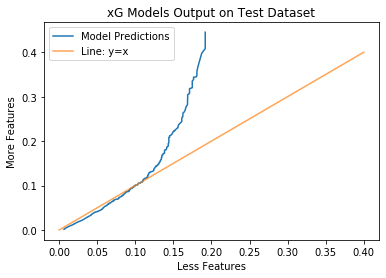

In [26]:
#now let's see how different these two models are
RMSLerror2 =  np.square(np.subtract(smallxGList['xG'].tolist(),xGList['xG'].tolist())).mean() #mean_squared_log_error(smallxGList['Goal'].tolist(),smallxGList['xG'].tolist())
print("Root Mean Squared Log error is:",RMSLerror2)
plt.figure()
plt.plot(smallxGList['xG'].tolist(),xGList['xG'].tolist(),label='Model Predictions')
plt.plot([0,0.4],[0,0.4],label='Line: y=x',alpha = 0.7)
plt.title('xCP Models Output on test dataset')
plt.title('xG Models Output on Test Dataset')
plt.xlabel('Less Features')
plt.ylabel('More Features')
plt.legend()
plt.show()

It seems as our simplified model is pretty consistent with the other when it comes to predicting low probability shots. Whereas it is more conservative when predicting higher probability shots

# Here we did a gridSearch to help optimize the parameters 

In [129]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_root_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
        pred = fitted_model.predict_proba(X_test_data)
    else:
        pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [134]:
from sklearn.model_selection import GridSearchCV
model = xgb.XGBRegressor()
param_grid = {
    'n_estimators': [400, 700, 1000],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [4,6,8],
    'eta':[0.5,0.4,0.3,0.15],
    'gamma': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9]
}

model, pred = algorithm_pipeline(XtrainxG, XtestxG, ytrainxG, ytestxG, model, 
                                 param_grid, cv=5)

# Root Mean Squared Error
print(np.sqrt(-model.best_score_))
print(model.best_params_)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 31.2min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 42.3min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed: 54.9min
[Parallel(n_jobs=-1)]: Done 3240 out of 3240 | elapsed: 68.6min finished


[16:06:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.4671002213499856
{'colsample_bytree': 0.7, 'eta': 0.5, 'gamma': 1, 'max_depth': 6, 'n_estimators': 400, 'subsample': 0.9}


# Chart the results to visualize our xG Predictions

In [16]:
#now let's chart the results
xGList = pd.concat([XtestsmallCopy['xG'],ytestsmall],axis=1,keys=['xG','Goal'])

xGList = xGList.sort_values(by=['xG'])
indexList = np.arange(len(xGList))
[xGbin_means,Gbin_means], bin_edges, binnumber = stats.binned_statistic(indexList,[xGList['xG'], xGList['Goal']],statistic='mean', bins=50)

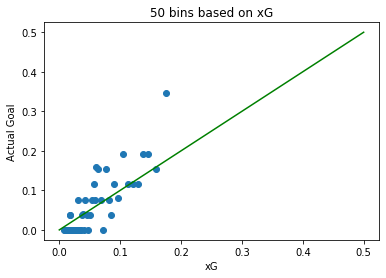

In [17]:
plt.figure()
#plt.hlines(bin_means, bin_edges[:-1], bin_edges[1:], colors='g', lw=2,label='binned statistic of data')
plt.plot(xGbin_means,Gbin_means,marker='o',linestyle='none')
#x = np.linspace(0,0.5,num=50)
plt.plot([0,0.5],[0,0.5],color='green')
plt.xlabel('xG')
plt.ylabel('Actual Goal')
plt.title('50 bins based on xG')
plt.show()

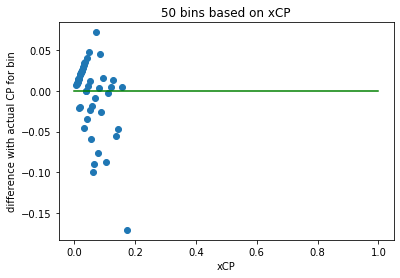

In [18]:
plt.figure()
plt.plot(xGbin_means,np.subtract(xGbin_means,Gbin_means),marker='o',linestyle='none')
plt.plot(np.linspace(0,1,num=100),np.zeros(100),color='green')
plt.xlabel('xCP')
plt.ylabel('difference with actual CP for bin')
plt.title('50 bins based on xCP')
plt.show()

In [19]:
binError = np.subtract(xGbin_means,Gbin_means)
binError = [abs(ele) for ele in binError]
print("average error is:",sum(binError)/len(binError))

average error is: 0.031273232315566675


# Now we can get Goals and Assists Over Expectation per (Otters) player

In [20]:
def getGOE(df,xGdf):
    df = df.copy()
    df['PriorEvent'] = df['Event'].shift(1)
    #df['PriorTime'] = df['Clock'].shift(1)
    #     this can be used if I want shot to be within 3ish seconds of pass
    df['PriorPlayer'] = df['Player'].shift(1)
    
    df = df.loc[(df['Event'] ==  'Goal' ) | (df['Event'] == 'Shot')]
    df = df[['Player','Event','PriorPlayer','PriorEvent']]
    df['Goal'] = df.apply(lambda row: 1 if (row['Event'] == 'Goal') else 0,axis=1)
    df['Miss'] = df.apply(lambda row: 1 if (row['Event'] == 'Shot') else 0,axis=1)
    xGdf = xGdf.copy()
    xGdf = xGdf[['xG']]
    merged = xGdf.merge(df,how='left',left_index=True,right_index=True)
    AOE = merged.loc[merged['PriorEvent'] == 'Play'].copy()
    AOE = AOE[['PriorPlayer','Goal','Miss','xG']]
    AOE = AOE.rename(columns={'PriorPlayer':'Player','Goal':'Assist','Miss':'MissedAssistShot','xG':'xA'})
    AOE = AOE.groupby(by=['Player']).sum()
    AOE['AOE'] = AOE.apply(lambda row: row['Assist'] - row['xA'],axis=1)
    AOE['TotalAssistShots'] = AOE.apply(lambda row: row['Assist'] + row['MissedAssistShot'],axis=1)
    AOE['AOEPerShot'] = AOE['AOE'] / AOE['TotalAssistShots']
    
    #merged = merged.drop(columns=['Event'])
    GOE = merged[['Player','Goal','Miss','xG']]
    GOE = merged.groupby(by=['Player']).sum()
    GOE['GOE'] = GOE.apply(lambda row: row['Goal'] - row['xG'],axis=1)
    GOE['TotalShots'] = GOE.apply(lambda row: row['Goal'] + row['Miss'],axis=1)
    GOE['GOEPerShot'] = GOE['GOE'] / GOE['TotalShots']
    
    GandAOE = GOE.merge(AOE,how='outer',left_index=True,right_index=True)
    return GandAOE

In [21]:
xGandAdf = getGOE(dataScout,XtestsmallCopy)

In [22]:
#this will just give us the Otters players
xGandAdf.loc[xGandAdf['TotalShots'] > 20]

,xG,Goal,Miss,GOE,TotalShots,GOEPerShot,Assist,MissedAssistShot,xA,AOE,TotalAssistShots,AOEPerShot
Player,,,,,,,,,,,,
Austen Swankler,3.503774,1.0,56.0,-2.503774,57.0,-0.043926,2.0,28.0,1.533612,0.466388,30.0,0.015546
Brendan Hoffmann,1.849209,2.0,27.0,0.150791,29.0,0.005200,2.0,14.0,1.084754,0.915246,16.0,0.057203
Brendan Sellan,3.090072,2.0,37.0,-1.090072,39.0,-0.027951,1.0,26.0,1.481129,-0.481129,27.0,-0.017820
Chad Yetman,4.758332,8.0,59.0,3.241668,67.0,0.048383,1.0,33.0,1.823646,-0.823646,34.0,-0.024225
Connor Lockhart,1.636526,2.0,22.0,0.363474,24.0,0.015145,1.0,20.0,1.059833,-0.059833,21.0,-0.002849
Daniel D'Amato,3.836610,5.0,41.0,1.163390,46.0,0.025291,1.0,22.0,1.435779,-0.435779,23.0,-0.018947
Drew Hunter,0.642195,0.0,25.0,-0.642195,25.0,-0.025688,1.0,18.0,1.168550,-0.168550,19.0,-0.008871
Emmett Sproule,2.612001,1.0,37.0,-1.612001,38.0,-0.042421,0.0,25.0,1.173710,-1.173710,25.0,-0.046948
Hayden Fowler,2.271039,1.0,35.0,-1.271039,36.0,-0.035307,1.0,16.0,1.103903,-0.103903,17.0,-0.006112
